In [1]:
import sys, pathlib
sys.path.insert(0, str(pathlib.Path.cwd().parent.parent))  # add repo root

from pathlib import Path
import json
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import cmcrameri.cm as cm

import networkx as nx
from ndtools.graphs import build_graph

## Load data


In [2]:
DATASET = Path("data") 
OUTPUT = Path("post-processing")

nodes = json.loads((DATASET / "nodes.json").read_text(encoding="utf-8"))
edges = json.loads((DATASET / "edges.json").read_text(encoding="utf-8"))
probs_dict = json.loads((DATASET / "probs_eq.json").read_text(encoding="utf-8"))
robustness_indices = json.loads((DATASET / "robustness_indices.json").read_text(encoding="utf-8"))

print("Data loaded from data/")

Data loaded from data/


## Build graph

In [3]:
G_base: nx.Graph = build_graph(nodes, edges, probs_dict)

pos = {}
for n, xy in nodes.items():
    if isinstance(xy, dict):
        pos[n] = (float(xy["x"]), float(xy["y"]))
    else:
        pos[n] = (float(xy[0]), float(xy[1]))

# Map node names to numbers (stable order by dict order)
node_number_map = {name: str(i+1) for i, name in enumerate(nodes)}

# Numeric node labels
numeric_node_labels = {node: num for node, num in node_number_map.items()}

# Numeric edge labels
edges_with_id = []
for u, v, data in G_base.edges(data=True):
    eid = data.get("eid")
    if eid is None:
        raise ValueError("Edge without 'eid' attribute found in G_base.")
    edges_with_id.append((u, v, eid))

edges_with_id.sort(key=lambda t: int(t[2][1:]))  # sort by numeric part of e0001

# map eid -> number
edge_number_map = {eid: str(i + 1) for i, (_, _, eid) in enumerate(edges_with_id)}

# build (u,v) -> label dict for nx.draw_networkx_edge_labels
numeric_edge_labels = {}
for u, v, eid in edges_with_id:
    lab = edge_number_map[eid]
    numeric_edge_labels[(u, v)] = lab
    numeric_edge_labels[(v, u)] = lab   # undirected safety

print("Node and edge labels prepared.")

Node and edge labels prepared.


## Styling

In [4]:
# Styling
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 16
plt.rc('font', family='times')

print("Styling set.")

Styling set.


## Plot of network

C:\Users\caol\AppData\Local\Temp\ipykernel_1720\2592156165.py:30: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.90, 1])


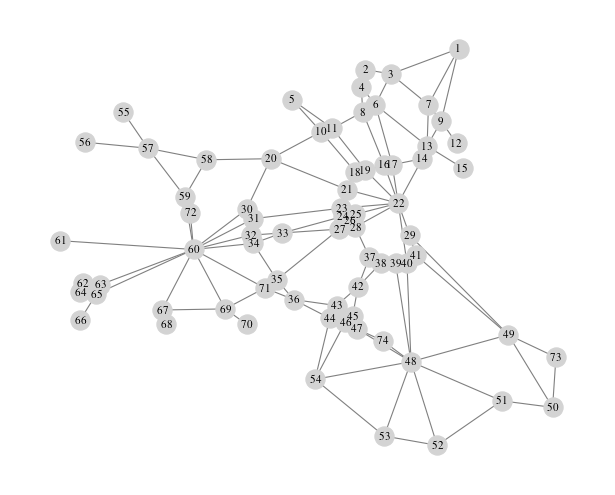

In [5]:
# Node color
node_color = "lightgray"

edges_sorted = sorted(G_base.edges(data=True), key=lambda e: int(e[2]["eid"][1:]))
edgelist = [(u, v) for (u, v, _) in edges_sorted]

# Plot size
plt.figure(figsize=plt.figaspect(0.8)*1.25, dpi=80)

# Draw graph
nx.draw(G_base, pos,
        edgelist=edgelist,
        horizontalalignment='center',
        verticalalignment='center',
        labels=numeric_node_labels,
        with_labels=True,
        font_size=10,
        font_color='black',
        node_color=(node_color if node_color is not None else 'lightgrey'),
        edge_color='gray'
        )

# # Draw edge labels
# nx.draw_networkx_edge_labels(G_base, pos,
#                              edge_labels=numeric_edge_labels,
#                              font_size=8,
#                              rotate=False)

# Adjust layout
plt.tight_layout(rect=[0, 0, 0.90, 1])

# Save figure
plt.savefig(OUTPUT / "network.pdf", dpi=300, bbox_inches='tight')
plt.savefig(OUTPUT / "network.svg", dpi=300, bbox_inches='tight')


plt.show()

## Colormap with 3-state entropy-based robustness index

C:\Users\caol\AppData\Local\Temp\ipykernel_1720\1845066509.py:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.90, 1])


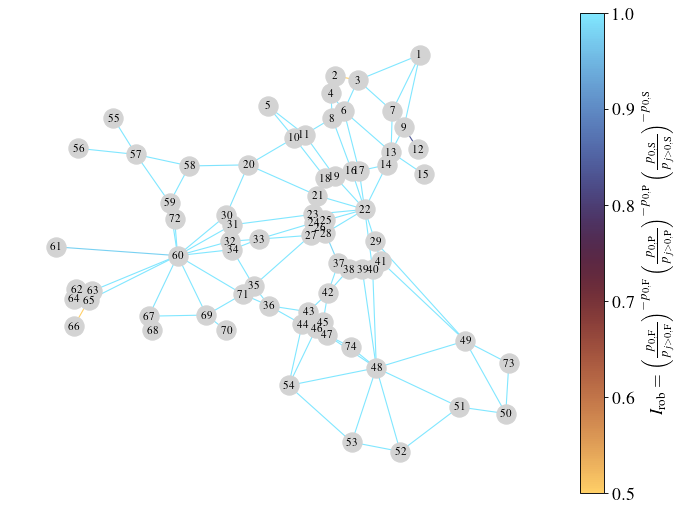

In [6]:
# --- parameters ---
# ROB_MIN, ROB_MAX = 0.16, 0.84
ROB_MIN, ROB_MAX = 0.5,1
ROB_RANGE = ROB_MAX - ROB_MIN

# Node color
node_color = "lightgray"

# Edge colors by robustness index, clipped to [ROB_MIN, ROB_MAX]
rob_by_eid_multi = {d["Component"]: float(d["Robustness index, multi-state"]) for d in robustness_indices}

edges_sorted = sorted(G_base.edges(data=True), key=lambda e: int(e[2]["eid"][1:]))
edgelist = [(u, v) for (u, v, _) in edges_sorted]

def clip(x, lo=ROB_MIN, hi=ROB_MAX):
    return lo if x < lo else hi if x > hi else x

edge_colors = [cm.managua((clip(rob_by_eid_multi[eid]) - ROB_MIN) / ROB_RANGE)
               for (_, _, data) in edges_sorted
               for eid in [data["eid"]]]

# Plot size
plt.figure(figsize=plt.figaspect(0.8)*1.25, dpi=80)

# Draw graph
nx.draw(G_base, pos,
        edgelist=edgelist,
        horizontalalignment='center',
        verticalalignment='center',
        labels=numeric_node_labels,
        with_labels=True,
        font_size=10,
        font_color='black',
        node_color=(node_color if node_color is not None else 'lightgrey'),
        edge_color=edge_colors
        )

# # Draw edge labels
# nx.draw_networkx_edge_labels(G_base, pos,
#                              edge_labels=numeric_edge_labels,
#                              font_size=8,
#                              rotate=False)

# Colorbar
fig = plt.gcf()
ax = plt.gca()
sm = plt.cm.ScalarMappable(cmap=cm.managua, norm=plt.Normalize(vmin=ROB_MIN, vmax=ROB_MAX))
sm.set_array([])
fig.colorbar(sm, ax=ax, fraction=0.046, pad=0.04, label=r"$I_{\mathrm{rob}} = \left(\frac{p_{0,\mathrm{F}}}{p_{j>0,\mathrm{F}}}\right)^{-p_{0,\mathrm{F}}} \left(\frac{p_{0,\mathrm{P}}}{p_{j>0,\mathrm{P}}}\right)^{-p_{0,\mathrm{P}}} \left(\frac{p_{0,\mathrm{S}}}{p_{j>0,\mathrm{S}}}\right)^{-p_{0,\mathrm{S}}}$")

# Adjust layout
plt.tight_layout(rect=[0, 0, 0.90, 1])

# Save figure
plt.savefig(OUTPUT / "network_Irob_multi.pdf", dpi=300, bbox_inches='tight')
plt.savefig(OUTPUT / "network_Irob_multi.svg", dpi=300, bbox_inches='tight')


plt.show()

## Colormap with binary-state entropy-based robustness index

C:\Users\caol\AppData\Local\Temp\ipykernel_1720\2677268774.py:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.90, 1])


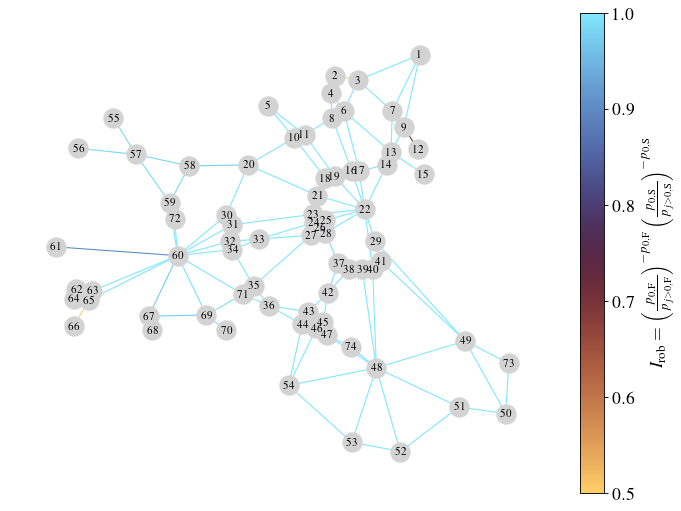

In [7]:
# --- parameters ---
# ROB_MIN, ROB_MAX = 0.16, 0.84
ROB_MIN, ROB_MAX = 0.5,1
ROB_RANGE = ROB_MAX - ROB_MIN

# Node color
node_color = "lightgray"

# Edge colors by robustness index, clipped to [ROB_MIN, ROB_MAX]
rob_by_eid_binary = {d["Component"]: float(d["Robustness index, binary"]) for d in robustness_indices}

edges_sorted = sorted(G_base.edges(data=True), key=lambda e: int(e[2]["eid"][1:]))
edgelist = [(u, v) for (u, v, _) in edges_sorted]

def clip(x, lo=ROB_MIN, hi=ROB_MAX):
    return lo if x < lo else hi if x > hi else x

edge_colors = [cm.managua((clip(rob_by_eid_binary[eid]) - ROB_MIN) / ROB_RANGE)
               for (_, _, data) in edges_sorted
               for eid in [data["eid"]]]

# Plot size
plt.figure(figsize=plt.figaspect(0.8)*1.25, dpi=80)

# Draw graph
nx.draw(G_base, pos,
        edgelist=edgelist,
        horizontalalignment='center',
        verticalalignment='center',
        labels=numeric_node_labels,
        with_labels=True,
        font_size=10,
        font_color='black',
        node_color=(node_color if node_color is not None else 'lightgrey'),
        edge_color=edge_colors
        )

# # Draw edge labels
# nx.draw_networkx_edge_labels(G_base, pos,
#                              edge_labels=numeric_edge_labels,
#                              font_size=8,
#                              rotate=False)

# Colorbar
fig = plt.gcf()
ax = plt.gca()
sm = plt.cm.ScalarMappable(cmap=cm.managua, norm=plt.Normalize(vmin=ROB_MIN, vmax=ROB_MAX))
sm.set_array([])
fig.colorbar(sm, ax=ax, fraction=0.046, pad=0.04, label=r"$I_{\mathrm{rob}} = \left(\frac{p_{0,\mathrm{F}}}{p_{j>0,\mathrm{F}}}\right)^{-p_{0,\mathrm{F}}} \left(\frac{p_{0,\mathrm{S}}}{p_{j>0,\mathrm{S}}}\right)^{-p_{0,\mathrm{S}}}$")

# Adjust layout
plt.tight_layout(rect=[0, 0, 0.90, 1])

# Save figure
plt.savefig(OUTPUT / "network_Irob_binary.pdf", dpi=300, bbox_inches='tight')
plt.savefig(OUTPUT / "network_Irob_binary.svg", dpi=300, bbox_inches='tight')

plt.show()

## Colormap with P(Partial failure | 1 component lost) in the pi-space

C:\Users\caol\AppData\Local\Temp\ipykernel_1720\3998825500.py:45: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.90, 1])


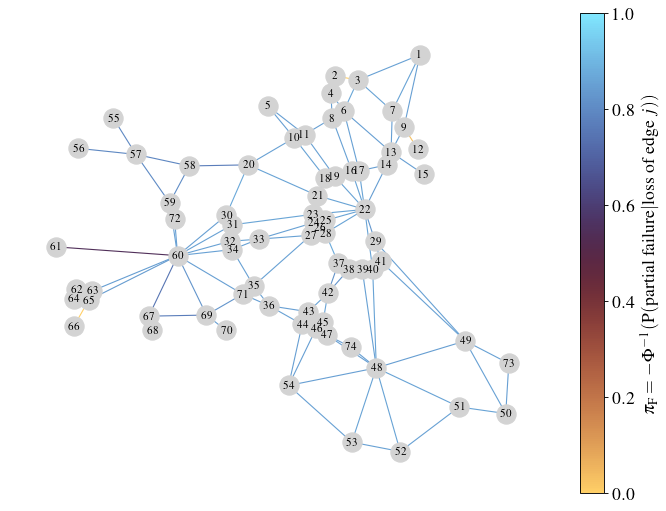

In [8]:
# --- parameters ---
PI_MIN, PI_MAX = 0, 1.0
PI_RANGE = PI_MAX - PI_MIN

# Node color
node_color = "lightgray"

# Edge colors by pi(partial failure), clipped to [PI_MIN, PI_MAX]
pi_by_eid = {d["Component"]: float(d["pi(partial failure)"]) for d in robustness_indices}

edges_sorted = sorted(G_base.edges(data=True), key=lambda e: int(e[2]["eid"][1:]))
edgelist = [(u, v) for (u, v, _) in edges_sorted]

def clip(x, lo=PI_MIN, hi=PI_MAX):
    return lo if x < lo else hi if x > hi else x

edge_colors = [cm.managua((clip(pi_by_eid[eid]) - PI_MIN) / PI_RANGE)
               for (_, _, data) in edges_sorted
               for eid in [data["eid"]]]

# Plot size
plt.figure(figsize=plt.figaspect(0.8)*1.25, dpi=80)

# Draw graph
nx.draw(G_base, pos,
        edgelist=edgelist,
        horizontalalignment='center',
        verticalalignment='center',
        labels=numeric_node_labels,
        with_labels=True,
        font_size=10,
        font_color='black',
        node_color=(node_color if node_color is not None else 'lightgrey'),
        edge_color=edge_colors
        )

# Colorbar
fig = plt.gcf()
ax = plt.gca()
sm = plt.cm.ScalarMappable(cmap=cm.managua, norm=plt.Normalize(vmin=PI_MIN, vmax=PI_MAX))
sm.set_array([])
fig.colorbar(sm, ax=ax, fraction=0.046, pad=0.04, label=r"$\pi_{\mathrm{F}}=-\Phi^{-1}\left(\mathrm{P}(\mathrm{partial\ failure}|\mathrm{loss\ of\ edge\ }j)\right)$")

# Adjust layout
plt.tight_layout(rect=[0, 0, 0.90, 1])

# Save figure
plt.savefig(OUTPUT / "network_pi_partialfail.pdf", dpi=300, bbox_inches='tight')
plt.savefig(OUTPUT / "network_pi_partialfail.svg", dpi=300, bbox_inches='tight')

plt.show()

## Colormap with P(System failure | 1 component lost) in the pi-space

C:\Users\caol\AppData\Local\Temp\ipykernel_1720\3609710089.py:45: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.90, 1])


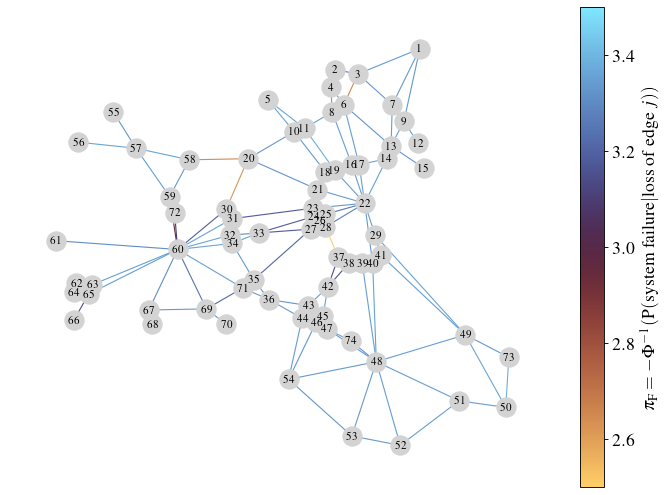

In [9]:
# --- parameters ---
PI_MIN, PI_MAX = 2.5, 3.5
PI_RANGE = PI_MAX - PI_MIN

# Node color
node_color = "lightgray"

# Edge colors by pi(partial failure), clipped to [PI_MIN, PI_MAX]
pi_by_eid = {d["Component"]: float(d["pi(system failure)"]) for d in robustness_indices}

edges_sorted = sorted(G_base.edges(data=True), key=lambda e: int(e[2]["eid"][1:]))
edgelist = [(u, v) for (u, v, _) in edges_sorted]

def clip(x, lo=PI_MIN, hi=PI_MAX):
    return lo if x < lo else hi if x > hi else x

edge_colors = [cm.managua((clip(pi_by_eid[eid]) - PI_MIN) / PI_RANGE)
               for (_, _, data) in edges_sorted
               for eid in [data["eid"]]]

# Plot size
plt.figure(figsize=plt.figaspect(0.8)*1.25, dpi=80)

# Draw graph
nx.draw(G_base, pos,
        edgelist=edgelist,
        horizontalalignment='center',
        verticalalignment='center',
        labels=numeric_node_labels,
        with_labels=True,
        font_size=10,
        font_color='black',
        node_color=(node_color if node_color is not None else 'lightgrey'),
        edge_color=edge_colors
        )

# Colorbar
fig = plt.gcf()
ax = plt.gca()
sm = plt.cm.ScalarMappable(cmap=cm.managua, norm=plt.Normalize(vmin=PI_MIN, vmax=PI_MAX))
sm.set_array([])
fig.colorbar(sm, ax=ax, fraction=0.046, pad=0.04, label=r"$\pi_{\mathrm{F}}=-\Phi^{-1}\left(\mathrm{P}(\mathrm{system\ failure}|\mathrm{loss\ of\ edge\ }j)\right)$")

# Adjust layout
plt.tight_layout(rect=[0, 0, 0.90, 1])

# Save figure
plt.savefig(OUTPUT / "network_pi_systemfail.pdf", dpi=300, bbox_inches='tight')
plt.savefig(OUTPUT / "network_pi_systemfail.svg", dpi=300, bbox_inches='tight')

plt.show()